In [1]:
import re

import ebooklib
from ebooklib import epub
import nltk
from bs4 import BeautifulSoup
import altair as alt
import pandas as pd

In [2]:
books = [
    '../books/free/Great Expectations - Charles Dickens.epub',
    '../books/unfree/The Overstory - Richard Powers.epub'
]

book_choice = books[1]
book_choice

'../books/unfree/The Overstory - Richard Powers.epub'

In [3]:
def get_section_header(text):
    return text.strip().split("\n")[0]

In [4]:
book = epub.read_epub(book_choice)
items = book.get_items_of_type(ebooklib.ITEM_DOCUMENT)

d = {}
for item in items:
    
    name = item.get_name()
    id_ = item.get_id()
    
    content = item.get_body_content()
    soup = BeautifulSoup(content)
    text = soup.get_text()
    
    header = get_section_header(text)
    
    d[id_] = dict(
        section_name=name,
        section_id=id_,
        text=text,
        header=header,
    )

In [5]:
# ids
sections = list(d.keys())
sections

['Cover',
 'toc',
 'title',
 'ch1',
 'ch2',
 'ch3',
 'ch4',
 'ch5',
 'ch6',
 'ch7',
 'ch8',
 'ch9',
 'ch10',
 'ch11',
 'ch12',
 'also',
 'ded',
 'epi',
 'copy']

In [6]:
# names
[x['section_name'] for x in d.values()]

['cover.xhtml',
 'toc.xhtml',
 'title.xhtml',
 'ch1.xhtml',
 'ch2.xhtml',
 'ch3.xhtml',
 'ch4.xhtml',
 'ch5.xhtml',
 'ch6.xhtml',
 'ch7.xhtml',
 'ch8.xhtml',
 'ch9.xhtml',
 'ch10.xhtml',
 'ch11.xhtml',
 'ch12.xhtml',
 'also.xhtml',
 'ded.xhtml',
 'epi.xhtml',
 'copy.xhtml']

In [7]:
def show_preview(i):
    section = sections[i]
    print("id:", section)
    print("name:", d[section]['section_name'])
    print("header:", d[section]['header'])
    
    text = d[section]['text']
    print("="*50)
    display(text[:200])
    print("...")
    display(text[-200:])

In [8]:
show_preview(4)

id: ch2
name: ch2.xhtml
header: NICHOLAS HOEL


'\nNICHOLAS HOEL\n\nNOW IS THE TIME of chestnuts.\nPeople are hurling stones at the giant trunks. The nuts fall all around them in a divine hail. It happens in countless places this Sunday, from Georgia to'

...


'he breeze as if this moment, too, so insignificant, so transitory, will be written into its rings and prayed over by branches that wave their semaphores against the bluest of midwestern winter skies.\n'

## Get Main Content

In [9]:
content = {}
for section, v in d.items():
    if "ch" in section:
        chapter_num = int(''.join(filter(str.isdigit, v['section_id'])))
        title = f"{chapter_num:02} - {v['header']}"
        content[title] = v

In [10]:
content_keys = list(content.keys())
content_keys

['01 - ROOTS',
 '02 - NICHOLAS HOEL',
 '03 - MIMI MA',
 '04 - ADAM APPICH',
 '05 - RAY BRINKMAN AND DOROTHY CAZALY',
 '06 - DOUGLAS PAVLICEK',
 '07 - NEELAY MEHTA',
 '08 - PATRICIA WESTERFORD',
 '09 - OLIVIA VANDERGRIFF',
 '10 - TRUNK',
 '11 - CROWN',
 '12 - SEEDS']

In [11]:
k = content_keys[0]
content[k].keys()

dict_keys(['section_name', 'section_id', 'text', 'header'])

## Word Counts

In [12]:
chapters = []
counts = []

for title, v in content.items():
    chapters.append(title)
    counts.append(len(v['text']))

data = pd.DataFrame(dict(
    chapter=chapters,
    word_count=counts
))

data

,chapter,word_count
0,01 - ROOTS,2360
1,02 - NICHOLAS HOEL,40451
2,03 - MIMI MA,44610
3,04 - ADAM APPICH,32358
4,05 - RAY BRINKMAN AND DOROTHY CAZALY,16053
5,06 - DOUGLAS PAVLICEK,38900
6,07 - NEELAY MEHTA,42932
7,08 - PATRICIA WESTERFORD,69615
8,09 - OLIVIA VANDERGRIFF,15499
9,10 - TRUNK,386394


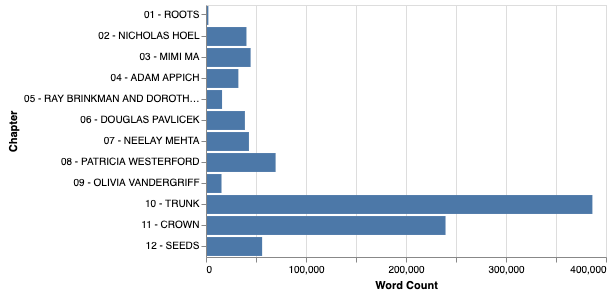

In [13]:
alt.Chart(data).mark_bar().encode(
    alt.X('word_count', title='Word Count'),
    alt.Y('chapter', title='Chapter'),
)

## Freq Words

In [14]:
import operator
from functools import reduce

from nltk.corpus import stopwords
from collections import Counter

In [33]:
stop_words = set(stopwords.words('english')) 

def get_freq_words(section_id):
    text = d[section_id]['text']
    
    # tokenize
    word_tokens = nltk.word_tokenize(text)

    # remove punctuation
    words = [word.lower() for word in word_tokens if word.isalpha()]

    # remove stop words
    filtered_words = [w for w in words if not w in stop_words]
    
    c = Counter(filtered_words)
    return c.most_common(5)

In [34]:
counts = []
for title, v in content.items():
    res = get_freq_words(v['section_id'])
    res = [(*t, title) for t in res]
    counts.append(res)

counts_joined = reduce(operator.add, counts)

data = pd.DataFrame(counts_joined, columns=['word', 'count', 'chapter'])
data.sample(n=5)

,word,count,chapter
46,one,209,10 - TRUNK
51,like,159,11 - CROWN
31,like,42,07 - NEELAY MEHTA
54,two,92,11 - CROWN
2,right,4,01 - ROOTS


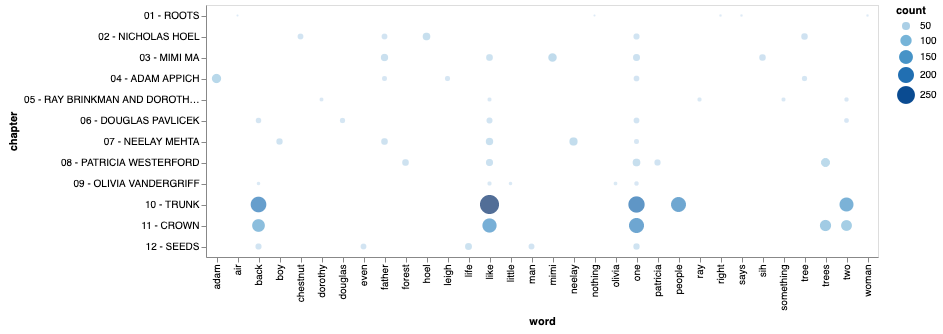

In [42]:
chart = alt.Chart(data, background='white').mark_circle().encode(
    x='word',
    y='chapter',
    size='count',
    color='count',
    tooltip=['word', 'chapter', 'count'],
).interactive()

chart

In [43]:
chart.save('chart.png', scale_factor=2.0)

## More NLTK

#### Note about stop words

Issue with contractions. Maybe alternative tokenizer better?

In [94]:
s = "I can't go. I don't want to."
tokens = nltk.word_tokenize(s)
tokens

['I', 'ca', "n't", 'go', '.', 'I', 'do', "n't", 'want', 'to', '.']

In [95]:
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)

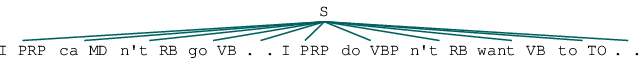

In [96]:
entities

In [ ]:
entities.

In [16]:
text = d['ch3.xhtml']['text']

In [17]:
sentence = text.split("\n\n")[1].split(".")[0]
sentence

'THE DAY IN 1948 when Ma Sih Hsuin gets his third-class ticket for a crossing to San Francisco, his father starts addressing him in English'

In [18]:
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)

In [19]:
tagged[:5]

[('THE', 'DT'), ('DAY', 'NNP'), ('IN', 'NNP'), ('1948', 'CD'), ('when', 'WRB')]

In [20]:
 nltk.help.upenn_tagset('NNP')

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...


In [21]:
trees = [x for x in entities if type(x) == nltk.tree.Tree]
trees

[Tree('PERSON', [('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]),
 Tree('GPE', [('San', 'NNP'), ('Francisco', 'NNP')]),
 Tree('GPE', [('English', 'NNP')])]

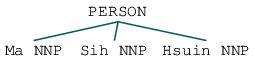

In [22]:
t = trees[0]
t

In [24]:
t.label()

'PERSON'

In [33]:
t.leaves()

[('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]

In [34]:
for match in re.finditer(r"\bMa\b", text):
    print(match)
    start = match.start() - 20
    end = match.end() + 20
    
    print(text[start:end])
    print()

In [31]:
# name = r"\bHoel\b"
# name = r"\bMa\b"
name = r"[19]\d\d"  # a year?

In [35]:
for section, v in d.items():
    print("========")
    print(section)
    text = v['text']
    for match in re.finditer(name, text):
        print(match)
        start = match.start() - 20
        end = match.end() + 20

        print(text[start:end])
        print()

cover.xhtml
toc.xhtml
title.xhtml
<re.Match object; span=(92, 95), match='192'>
nt Publishers Since 1923
NEW YORK   •   LON

ch1.xhtml
ch2.xhtml
<re.Match object; span=(13151, 13154), match='190'>
irst day of spring, 1903, John Hoel positio

<re.Match object; span=(14151, 14154), match='190'>
 again on March 21, 1904, as if he, too, mi

<re.Match object; span=(19758, 19761), match='194'>
never disappear. By 1940, the fungus takes 

<re.Match object; span=(22879, 22882), match='196'>
er cold of February 1965, the No. 2 Brownie

ch3.xhtml
<re.Match object; span=(21, 24), match='194'>
MIMI MA

THE DAY IN 1948 when Ma Sih Hsuin 

<re.Match object; span=(1390, 1393), match='191'>
ons by typhoon. The 1911 revolution and the

<re.Match object; span=(1855, 1858), match='194'>
 students in all of 1948 to be granted visa

<re.Match object; span=(10246, 10249), match='192'>
ng down November 7, 1925. In fact, he was b

<re.Match object; span=(13532, 13535), match='196'>
morning, midsummer, 1967, w